# Financial Data Structures: Imbalance Bars

上一节的Volume Bars和Dollar Bars统计特性还是不错，看看这节的Imbalance Bars情况如何

这个bar和传统的bar相差很远，它的核心在于某种能量往某一个方向累积偏离到一定的程度，就行成了一个bar，然后再重新累积这个能量。这个能量和上节一样有volume, dollar, ticks。

能量$b_t$的公式如下，t为时间，$p_t$为t时刻的价格,$\Delta p_t$为t时间相对于t-1时刻的价格变化


$$b_t = \begin{cases} b_{t-1}, & \mbox{if } \Delta p_t\mbox{=0} \\ |\Delta p_t| / \Delta p_{t}, & \mbox{if } \Delta p_t \neq\mbox{0} \end{cases}$$

$$\theta_{T} = \sum_{t=1}^{T}b_t$$

$\theta$就是累积的能量，上面是Tick Imbalance Bars的累积能量公式，当$\theta$超过一定阈值时就产生一个新的bar，然而这个阈值是动态生成的，用了指数移动平均线，具体方法可以看书中的解释和mlfinlab中的代码实现。

VIB的能量为volume，$\theta_T$的公式如下：

$$\theta_{T} = \sum_{t=1}^{T}b_t v_t$$

其实就是在单个能量值$b_t$的基础上乘了volume。如果往上形成了新的Volume Imbalance Bar，说明量价齐升进行了突破，当然这是主观分析中的思路，貌似这么分析也合理。

Dollar Imbalance Bars 的计算方式也类似，乘的是交易额。

Run Bars 和 Imbalance Bars一样是另一种Information-Driven Bar，只是他的 $\theta$ 取的多空方向中能量值绝对值较大的那一个。本篇文章重点分析一下Imbalance Bars，Run Bars不做分析。

合成Imbalance Bars需要用到逐笔的tick，但是国内期货的行情好像只有快照tick数据，那么用Imbalace Bars的方式产出Bar应该是不准确的。

因为快照数据中间缺失了很多订单数据，中间发生了什么我们都不太清楚。比如一个tick的信息为，20手，买入，价格上涨0.1元。这20手的组成是难以估算的，我以前尝试分析过，成交单的类型及数量还能做估算，但是两个tick间的价格变化就全然不知。

我这边就用快照tick数据测试一下，但是结果可能会不准确，纯属为了了解Imbalance Bars的特性。

---

Volume Bars and Dollar Bars statistics in the previous section are still good, see how is the Imbalance Bars in this section

This bar is a far cry from the traditional bar, and its core is that some energy accumulates in a certain direction to a certain extent, becomes a bar, and then reaccumulates that energy. This energy is the same as the upper section is volume, dollar, ticks.

The formula for energy $b_t$is as follows, t is time, $p_t$is the price of t-time, $\Delta p_t$is the price change of t-time relative to t-1 time

$$b_t = \begin{cases} b_{t-1}, & \mbox{if } \Delta p_t\mbox{=0} \\ |\Delta p_t| / \Delta p_{t}, & \mbox{if } \Delta p_t \neq\mbox{0} \end{cases}$$

$$\theta_{T} = \sum_{t=1}^{T}b_t$$

The $\theta$is the accumulated energy, above is the cumulative energy formula of Tick Imbalance Bars, which produces a new bar when the $\theta$ exceeds a certain threshold, however this threshold is dynamically generated, using exponential moving averages, which can be implemented in the interpretation of the book and the code in mlfinlab.

Dollar Imbalance Bars is calculated in a similar way, multiplied by the amount of tick.

Run Bars, like Imbalance Bars, is another Kind of Information-Driven Bar, just the one whose energy value is the absolute value of the larger in the long short direction of his $\theta$. This article focuses on Imbalance Bars, run Bars does not do analysis.

Synthetic Imbalance Bars requires a real tick, but the Chinese futures market data seems to have only snapshot tick, so it should be inaccurate to produce Bar in the way of Imbalace Bars.

Because there is a lot of order data missing from the snapshot data, we don't know what's going on in the middle. For example, a tick information is, 20 lots, buy, the price increases 0.1 yuan. The composition of these 20 lots is difficult to estimate, I have tried to analyze before, the type and number of deals can be estimated, but the price change between the two ticks is completely unknown.

I'll test it with snapshot tick data on my side, but the results may not be accurate, purely to understand the characteristics of The Imbalance Bars.


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf

from mlfinlab.data_structures_snapshot_tick.imbalance_data_structures import get_ema_tick_imbalance_bars, \
    get_ema_volume_imbalance_bars
from mlfinlab.data_structures_snapshot_tick.run_data_structures import get_ema_tick_run_bars, \
    get_ema_volume_run_bars

---
## 准备数据(Preparing data)

中国上海期货交易所的品种：螺纹钢(RB)。2019年整年的tick数据。

Instrument of Shanghai Futures Exchange: Rebar (RB). 2019 full-year tick data.

In [17]:
TICK_FILE_PATH = '../data/rb_1year_tick.csv'

def get_data_df():
    df = pd.read_csv(TICK_FILE_PATH)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df.set_index('date_time', inplace=True)
    return df

def generate_time_bars():
    df = get_data_df()
    return df, df['price'].resample('5min').ohlc().dropna()

def analysis_thresholds(imb_bars:pd.DataFrame, thresholds_df):
    thresholds_df['threshold'] = np.abs(thresholds_df['expected_imbalance']*thresholds_df['exp_num_ticks'])
    if 'timestamp' in thresholds_df.columns:
        thresholds_df.set_index('timestamp', inplace=True)

#     print(thresholds_df)
    
    thresholds_df_down_sample = thresholds_df.resample("5min").bfill()
    
    plt.figure(figsize=(10,12))
    ax1 = plt.subplot(311)

    thresholds_df_down_sample[['cum_theta', 'threshold']].plot(ax=ax1)
    plt.axhline(0, c='green')

    ax2 = plt.subplot(312)
    time_bars['close'].plot(ax=ax2, label='time bar')
    time_bars['imb_close'] = np.NaN
    
    last_time = None
    for row in imb_bars[['date_time', 'close']].itertuples():
        if last_time is None:
            time_bars['imb_close'].loc[time_bars.index<=row.date_time] = row.close
        else:
            time_bars['imb_close'].loc[(time_bars.index>last_time) & (time_bars.index<=row.date_time)] = row.close
        last_time = row.date_time
    time_bars['imb_close'].plot(ax=ax2, label='imbalance bar')
    plt.legend()

    ax3 = plt.subplot(313)
    thresholds_df_down_sample[['exp_num_ticks']].plot(ax=ax3)

    plt.show()
    
    imb_bars['log_ret'] = np.log(imb_bars['close']).diff().dropna()
    plt.figure(figsize=(14,10))
    sns.kdeplot((imb_bars.log_ret - imb_bars.log_ret.mean()) / imb_bars.log_ret.std(), label="Imbalance bars")
    sns.kdeplot(np.random.normal(size=len(imb_bars)), label="Normal", color='black', linestyle="--")
    plt.show()
    
    plot_acf(imb_bars['log_ret'].dropna(), lags=10, zero=False)
    plt.title('AutoCorrelation')
    plt.show()

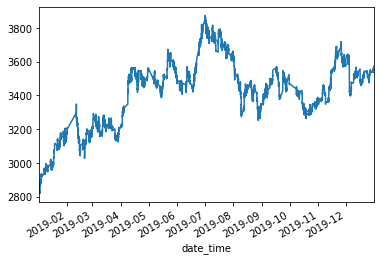

In [3]:
tick_df, time_bars = generate_time_bars()

time_bars['close'].plot()

In [4]:
print(tick_df.shape)
print(tick_df.head())

# nearly 10 million ticks

(9966335, 3)
                          price  volume       amount
date_time                                           
2019-01-02 08:59:00.500  2844.0       0          0.0
2019-01-02 09:00:00.500  2845.0    2274   77292540.0
2019-01-02 09:00:01.000  2846.0    4452  151464120.0
2019-01-02 09:00:01.500  2849.0    1794   61028560.0
2019-01-02 09:00:02.000  2851.0    1216   41385260.0


---
## Use mlfinlab: Create TIB Bars

In [5]:
TIB, TIB_thresholds_df = get_ema_tick_imbalance_bars(tick_df.reset_index(), analyse_thresholds=True,
                                 exp_num_ticks_constraints=[800, 80000])
TIB.head()

Reading data in batches:
Batch number: 0
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2019-01-02 14:01:43.000,20000,2844.0,2876.0,2817.0,2826.0,1734172,822048,20000,5.879379e+10
1,2019-01-02 14:05:16.000,20425,2825.0,2827.0,2822.0,2823.0,11368,4068,425,3.840314e+08
2,2019-01-02 14:22:15.000,22463,2824.0,2839.0,2823.0,2832.0,170310,107792,2038,5.767936e+09
3,2019-01-02 14:45:57.500,25308,2832.0,2834.0,2825.0,2825.0,112084,49732,2845,3.792436e+09
4,2019-01-02 21:04:21.000,27517,2825.0,2833.0,2816.0,2818.0,227944,106096,2209,7.700693e+09


我在获取TIB时，碰到了一些问题，在我没有加约束条件(exp_num_ticks_constraints[min_exp_num_ticks, max_exp_num_ticks])时，出现了如下情况，程序一直在运行，产生了无数根bar。

我们通过日志可以看到exp_num_ticks到后面一直是1，而expected_imbanlance 一直是个很小的数，他们相乘是个非常小的数远小于1，这样每个tick的b_value 1 都会大于这个阈值，会导致每个tick都会产生一根bar，我相信这是有问题的，而且运行很长时间也无法逃离这个困境。

想想其实可以发现，Tick Imbalance Bar 的expected_imbalance的期望其实是0，所以在实际环境中应该是接近于0的，如果exp_num_ticks也在衰减的话，那么一旦进入到1 * 0.00? 的困境中就会一直套在里面出不来

所以我加了最小800个tick的条件，最大80000个条件是因为有时exp_num_ticks会无限的增大，所以我觉得TIB这个算法是有些问题的，我并不觉得这种类型的bar能用在实际环境中。

下面为进入到困境时的日志。

---

When I got TIB, I had some problems. when I didn't add constraints (exp_num_ticks_constraints (min_exp_num_ticks, max_exp_num_ticks), the program was running all the time, producing countless bars.

We can see through the log that exp_num_ticks to the back has always been 1, and expected_imbanlance has always been a very small number, they multiply is a very small number far less than 1, so that each tick's b_value 1 will be greater than this threshold, resulting in each tick will produce a bar, I believe this is problematic, and run for a long time can not escape this dilemma.

Think about it, and you can see that the expected_imbalance expectation of Tick Imbalance Bars is actually 0, so in the real world it should be close to 0, and if the exp_num_ticks is also decaying, then once you get to 1 x 0.00? in the trouble will always be stuck in the inside out can not come out

So I added a minimum of 800 ticks, a maximum of 80,000 conditions because sometimes the exp_num_ticks will increase indefinitely, so I think the TIB algorithm is a bit of a problem, I don't think this type of bar can be used in the real environment.

Below is the log that enters the dilemma.

------------------------------------------------------------------------------------------
<pre>
new bar: cum_theta -393.0, exp_num_ticks 20000 * expected_imbalance 0.004606430289912242
new bar: cum_theta -93.0, exp_num_ticks 20000.0 * expected_imbalance 0.004606430289912242
new bar: cum_theta -126.0, exp_num_ticks 6950.0 * expected_imbalance -0.018082763088593235
new bar: cum_theta -161.0, exp_num_ticks 4143.142857142857 * expected_imbalance -0.03877713597093915
new bar: cum_theta -123.0, exp_num_ticks 2268.714285714286 * expected_imbalance -0.054159511732974945
new bar: cum_theta 147.0, exp_num_ticks 2366.285714285714 * expected_imbalance -0.06189258080298448
new bar: cum_theta 31.0, exp_num_ticks 1617.5714285714287 * expected_imbalance -0.018559776602432916
new bar: cum_theta 8.0, exp_num_ticks 711.2857142857143 * expected_imbalance -0.010290755421168463
new bar: cum_theta -2.0, exp_num_ticks 203.57142857142858 * expected_imbalance -0.008671808277382986
new bar: cum_theta -1.0, exp_num_ticks 30.428571428571427 * expected_imbalance -0.00913084853734123
new bar: cum_theta -1.0, exp_num_ticks 2.5714285714285716 * expected_imbalance -0.009391603348769791
new bar: cum_theta -1.0, exp_num_ticks 1.1428571428571428 * expected_imbalance -0.00965230601445051
new bar: cum_theta -1.0, exp_num_ticks 1.0 * expected_imbalance -0.009912956544811965
new bar: cum_theta -1.0, exp_num_ticks 1.0 * expected_imbalance -0.010173554950279636
new bar: cum_theta -1.0, exp_num_ticks 1.0 * expected_imbalance -0.010371500444740092
</pre>


### analysis TIB threshold

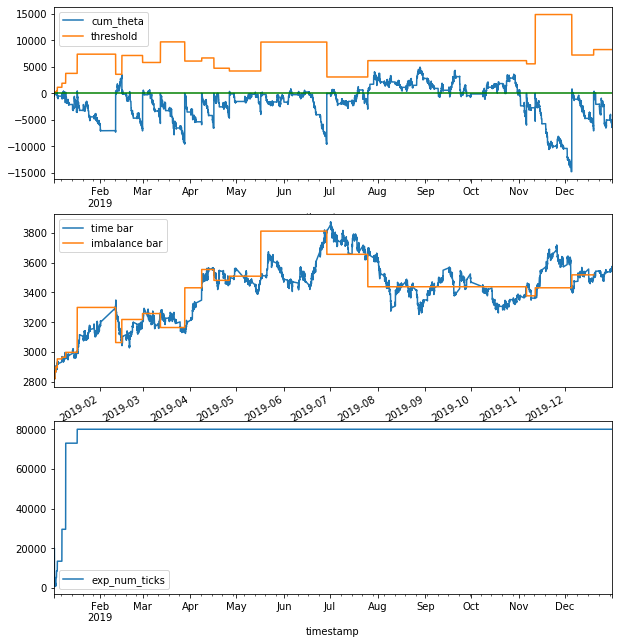

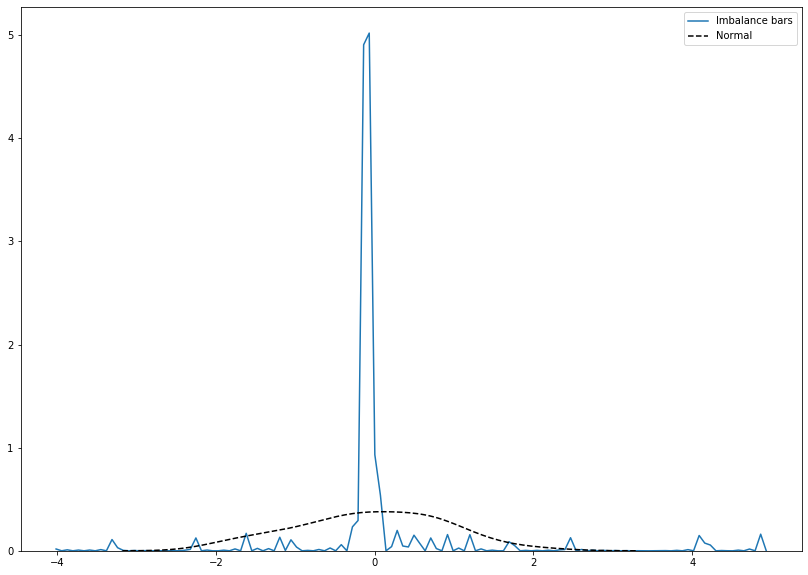

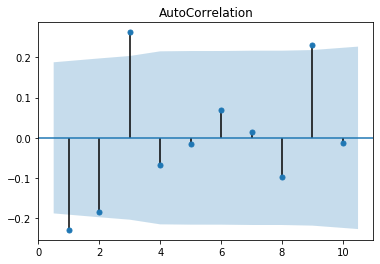

In [18]:
analysis_thresholds(TIB, TIB_thresholds_df)

analysis_thresholds 函数是我用来分析 Imbalance Bars 的。主要分析Threshold的变化，产生bar的情况。

第一张折线图画出了Threshold和$\theta$值的变化。可以看出前期Threshold有一个快速变化的过程，稳定后变化非常缓慢，一年也没有几根Bar。而且在后期有一段时间在震荡，一直没产生新的Bar。说到这里是不是可以把t时刻距离上一根Bar的时长当作一个特征呢？结合阈值的大小，当作Regime Switch的一个判断因子？瞎想的。

第二张折线图画出了价格趋势和Tick Imbalance Bars。和第一张结合起来一看，有点意思，很多时候行情上涨时TIB的$\theta$值下降速度很快，这里可以额外做一个相关性分析。假如从主观上分析是不是小单抛得多，大单扫得快？ 如果小单代表散户，大单代表主力资金，那么就是统计出来的小单的方向就是主力未来的反方向？

这些猜想都需要进行分析和实证才能知道。

第三张折线图画出了期望的Bar中的Tick数，很快就达到了我们设置的上限80000。现在来看TIB一个很大的问题就是调参，初始阈值，上限和下限，而且起始的t不一样，产出的Bar可能也不一样。

分布图就不用看了，Bars的量太小没什么意义。

我觉得TIB直接用可能有坑，需要再深入细化。

---

analysis_thresholds function is what I used to analyze Imbalance Bars. The main analysis of the changes in Threshold produces the bar situation.

The first line chart sits out the changes in the values of Threshold and $\theta$. It can be seen that the early threshold has a rapid change process, and the change process is very slow, there are just few Bars in a year. And there was a concussion at a later stage and there was no new Bar. 

Can it be said that the t-moment distance from the duration of the last Bar as a feature? Combined with the size of the threshold, as a judge on Regime Switch? I'm just thinking about it.

The second line chart illustrates the price trend and the Tick Imbalance Bars. 

Combined with the first one, it's a bit interesting, a lot of times when the market goes up, the value of TIB's $\theta$drops quickly, and here we can do an additional correlation analysis. 

If from a subjective analysis, is it not a small order to throw a lot, big order sweep faster? 

If small order on behalf of retail, large rorder represents the main fund, then is the direction of the small order is the main future of the opposite direction?

These guesses need to be analyzed and empirical.

The third line drawing the desired number of Ticks in the Bar quickly reached the upper limit of 80,000 set by us. One of the big problems with TIB now is the parameter tunning, initial threshold, upper limit and lower limit, and the starting t is different, and the output of The Bar may not be the same.

The distribution map doesn't have to be seen, and bars' size is too small to make sense.

I think TIB direct use may have pits, need to further research.

---
## Use mlfinlab: Create VIB Bars

In [19]:
VIB, VIB_thresholds_df = get_ema_volume_imbalance_bars(tick_df.reset_index(), analyse_thresholds=True,
                                 exp_num_ticks_constraints=[1300, 10000])
VIB.head()

Reading data in batches:
Batch number: 0
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2019-01-02 14:01:43.000,20000,2844.0,2876.0,2817.0,2826.0,1734172,822048,20000,5.879379e+10
1,2019-01-02 14:04:11.000,20295,2825.0,2827.0,2823.0,2823.0,8094,2434,295,2.734620e+08
2,2019-01-02 14:06:55.500,20624,2823.0,2828.0,2822.0,2828.0,12506,8012,329,4.226556e+08
3,2019-01-02 14:07:54.500,20742,2829.0,2829.0,2825.0,2826.0,5332,1782,118,1.802808e+08
4,2019-01-02 14:07:58.000,20749,2826.0,2827.0,2826.0,2827.0,84,84,7,2.840020e+06


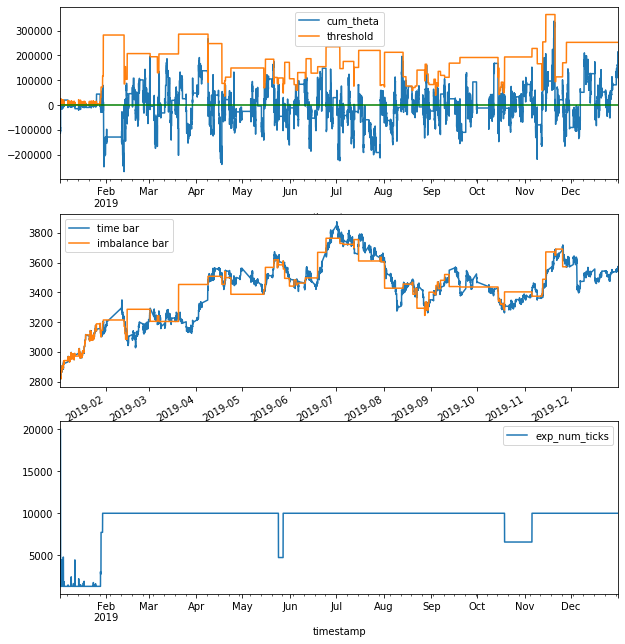

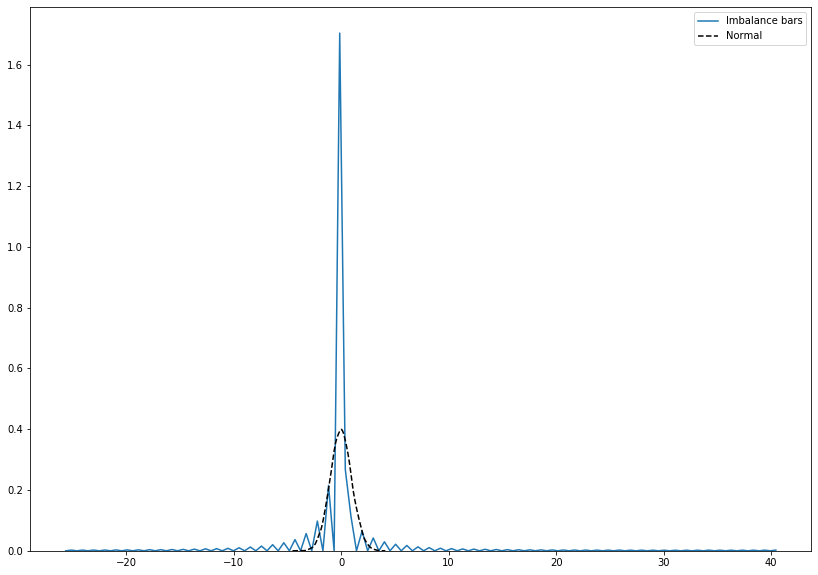

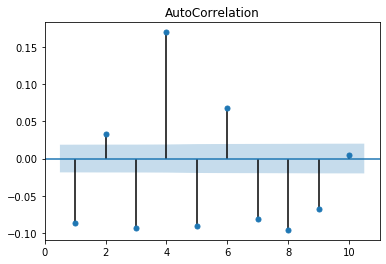

In [20]:
analysis_thresholds(VIB, VIB_thresholds_df)

VIB和TIB一样也需要调整exp_num_ticks_constraints才能让产生的bar更合理。

VIB, like TIB, needs to adjust exp_num_ticks_constraints to make the resulting bar more reasonable.

## 结论(Conclusion)

这样看下来，其实EMW动态调整阈值的形式其实不太靠谱，所以mlfinlab还准备了固定阈值的函数，想得很周到，我这里就不分析了。

用Imbalance Bars可能不是一件很容易的事，更何况国内的货期tick数据还是快照数据。

回顾一下上面两种 Imbalance Bars 的自相关性分析图，自相关性都很高，远远高于Standard Bars。Imbalance Bars的主要目标是每个Bar的信息量相等。 这就是为什么我们应该考虑使用信息理论来研究 Imbalance Bars 的特性。

---

In this way, the form of the EMW dynamic adjustment threshold is not quite reliable, so mlfinlab also prepared a fixed threshold function, think very thoughtful, but I will not analyze here.

Using Imbalance Bars may not be an easy task, not to mention domestic cargo tick data or snapshot data.

As we can see imbalance bars are more autocorrelated comparing to dollar bars, however, the key goal of imbalance/run bars is equal amount of information inside of each bar. That is why we should consider using information theory to research properties of imbalance bars in comparison with time/dollar bars.